In [4]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections
import random
import time

import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [23]:
# env = gym.envs.make('Ant-v2')
env = gym.envs.make('Swimmer-v2')
print(len(env.observation_space.high))
print(len(env.action_space.high))

# env = CliffWalkingEnv();
# env.action_space.n
observation_space = env.reset()
obs = []
for i in range(1500):
    obs.append(env.reset())
    

    
# # env.observation_space.sample()
# print(env.observation_space.high)
# # random.uniform(env.observation_space)

8
2


In [26]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(obs)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(obs))

FeatureUnion(n_jobs=None,
             transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=100,
                                           random_state=None)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=100,
                                           random_state=None)),
                               ('rbf3',
                                RBFSampler(gamma=1.0, n_components=100,
                                           random_state=None)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=100,
                                           random_state=None))],
             transformer_weights=None, verbose=False)

In [27]:
def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [6]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
#             self.state = tf.placeholder(tf.int32, [], "state")
#             self.state  = tf.placeholder(tf.int32, shape = (111), name= "state")
            self.state =  tf.placeholder(dtype=tf.float32, shape = (len(env.observation_space.high)), name = "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")
            
            # This is just table lookup estimator
            # observation_space : Box(111,)
            # action_space : Box(8,)
#             state_one_hot = tf.one_hot(self.state, 111)
#             state_one_hot = tf.one_hot(self.state, env.observation_space.n)
            self.output_layer = tf.contrib.layers.fully_connected(
#                 inputs=tf.expand_dims(state_one_hot, 0),
                inputs = tf.expand_dims(self.state,0),
                num_outputs=len(env.action_space.high),
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
    
            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)
            
            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [7]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
#             self.state = tf.placeholder(tf.int32, [], "state")
#             self.state = tf.placeholder(tf.int32, [], name= "state")
#             self.state = tf.placeholder(tf.int32,shape = (111), name= "state")
            self.state = tf.placeholder(dtype=tf.float32, shape = (len(env.observation_space.high)), name = "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
#             state_one_hot = tf.one_hot(self.state, 111)
#             state_one_hot = tf.one_hot(self.state, env.observation_space.n)
            self.output_layer = tf.contrib.layers.fully_connected(
#                 inputs=tf.expand_dims(state_one_hot, 0),
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [14]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the first action
        state = env.reset()
        print(state.shape)
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            action_probs = estimator_policy.predict(state)
            print(len(action_probs))
            action_index = np.random.choice(np.arange(len(action_probs)))
            action = action_probs[action_index]
            time.sleep(.002)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # sys.stdout.flush()
            if done:
                break
                
            state = next_state

        # Go through the episode and make policy updates
        for t, transition in enumerate(episode):
            # The return after this timestep
            total_return = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            # Calculate baseline/advantage
            baseline_value = estimator_value.predict(transition.state)            
            advantage = total_return - baseline_value
            # Update our value estimator
            estimator_value.update(transition.state, total_return)
            # Update our policy estimator
            estimator_policy.update(transition.state, advantage, transition.action)
        
    return stats

In [16]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well for me.
    stats = reinforce(env, policy_estimator, value_estimator, 4, discount_factor=1.0)
# for i in range(100):
#     env.render() 
#     action_index = np.random.choice(np.arange(len(action_probs)))
#     action = action_probs[action_index]
#     time.sleep(.002)
#     next_state, reward, done, _ = env.step(action)

(8,)
[0.5 0.5]
Step 0 @ Episode 1/4 (0.0)[0.5 0.5]
Step 1 @ Episode 1/4 (0.0)[0.5 0.5]
Step 2 @ Episode 1/4 (0.0)[0.5 0.5]
Step 3 @ Episode 1/4 (0.0)[0.5 0.5]
Step 4 @ Episode 1/4 (0.0)[0.5 0.5]
Step 5 @ Episode 1/4 (0.0)[0.5 0.5]
Step 6 @ Episode 1/4 (0.0)[0.5 0.5]
Step 7 @ Episode 1/4 (0.0)[0.5 0.5]
Step 8 @ Episode 1/4 (0.0)[0.5 0.5]
Step 9 @ Episode 1/4 (0.0)[0.5 0.5]
Step 10 @ Episode 1/4 (0.0)[0.5 0.5]
Step 11 @ Episode 1/4 (0.0)[0.5 0.5]
Step 12 @ Episode 1/4 (0.0)[0.5 0.5]
Step 13 @ Episode 1/4 (0.0)[0.5 0.5]
Step 14 @ Episode 1/4 (0.0)[0.5 0.5]
Step 15 @ Episode 1/4 (0.0)[0.5 0.5]
Step 16 @ Episode 1/4 (0.0)[0.5 0.5]
Step 17 @ Episode 1/4 (0.0)[0.5 0.5]
Step 18 @ Episode 1/4 (0.0)[0.5 0.5]
Step 19 @ Episode 1/4 (0.0)[0.5 0.5]
Step 20 @ Episode 1/4 (0.0)[0.5 0.5]
Step 21 @ Episode 1/4 (0.0)[0.5 0.5]
Step 22 @ Episode 1/4 (0.0)[0.5 0.5]
Step 23 @ Episode 1/4 (0.0)[0.5 0.5]
Step 24 @ Episode 1/4 (0.0)[0.5 0.5]
Step 25 @ Episode 1/4 (0.0)[0.5 0.5]
Step 26 @ Episode 1/4 (0.0)[0.5 0

Step 222 @ Episode 1/4 (0.0)[0.5 0.5]
Step 223 @ Episode 1/4 (0.0)[0.5 0.5]
Step 224 @ Episode 1/4 (0.0)[0.5 0.5]
Step 225 @ Episode 1/4 (0.0)[0.5 0.5]
Step 226 @ Episode 1/4 (0.0)[0.5 0.5]
Step 227 @ Episode 1/4 (0.0)[0.5 0.5]
Step 228 @ Episode 1/4 (0.0)[0.5 0.5]
Step 229 @ Episode 1/4 (0.0)[0.5 0.5]
Step 230 @ Episode 1/4 (0.0)[0.5 0.5]
Step 231 @ Episode 1/4 (0.0)[0.5 0.5]
Step 232 @ Episode 1/4 (0.0)[0.5 0.5]
Step 233 @ Episode 1/4 (0.0)[0.5 0.5]
Step 234 @ Episode 1/4 (0.0)[0.5 0.5]
Step 235 @ Episode 1/4 (0.0)[0.5 0.5]
Step 236 @ Episode 1/4 (0.0)[0.5 0.5]
Step 237 @ Episode 1/4 (0.0)[0.5 0.5]
Step 238 @ Episode 1/4 (0.0)[0.5 0.5]
Step 239 @ Episode 1/4 (0.0)[0.5 0.5]
Step 240 @ Episode 1/4 (0.0)[0.5 0.5]
Step 241 @ Episode 1/4 (0.0)[0.5 0.5]
Step 242 @ Episode 1/4 (0.0)[0.5 0.5]
Step 243 @ Episode 1/4 (0.0)[0.5 0.5]
Step 244 @ Episode 1/4 (0.0)[0.5 0.5]
Step 245 @ Episode 1/4 (0.0)[0.5 0.5]
Step 246 @ Episode 1/4 (0.0)[0.5 0.5]
Step 247 @ Episode 1/4 (0.0)[0.5 0.5]
Step 248 @ E

Step 451 @ Episode 1/4 (0.0)[0.5 0.5]
Step 452 @ Episode 1/4 (0.0)[0.5 0.5]
Step 453 @ Episode 1/4 (0.0)[0.5 0.5]
Step 454 @ Episode 1/4 (0.0)[0.5 0.5]
Step 455 @ Episode 1/4 (0.0)[0.5 0.5]
Step 456 @ Episode 1/4 (0.0)[0.5 0.5]
Step 457 @ Episode 1/4 (0.0)[0.5 0.5]
Step 458 @ Episode 1/4 (0.0)[0.5 0.5]
Step 459 @ Episode 1/4 (0.0)[0.5 0.5]
Step 460 @ Episode 1/4 (0.0)[0.5 0.5]
Step 461 @ Episode 1/4 (0.0)[0.5 0.5]
Step 462 @ Episode 1/4 (0.0)[0.5 0.5]
Step 463 @ Episode 1/4 (0.0)[0.5 0.5]
Step 464 @ Episode 1/4 (0.0)[0.5 0.5]
Step 465 @ Episode 1/4 (0.0)[0.5 0.5]
Step 466 @ Episode 1/4 (0.0)[0.5 0.5]
Step 467 @ Episode 1/4 (0.0)[0.5 0.5]
Step 468 @ Episode 1/4 (0.0)[0.5 0.5]
Step 469 @ Episode 1/4 (0.0)[0.5 0.5]
Step 470 @ Episode 1/4 (0.0)[0.5 0.5]
Step 471 @ Episode 1/4 (0.0)[0.5 0.5]
Step 472 @ Episode 1/4 (0.0)[0.5 0.5]
Step 473 @ Episode 1/4 (0.0)[0.5 0.5]
Step 474 @ Episode 1/4 (0.0)[0.5 0.5]
Step 475 @ Episode 1/4 (0.0)[0.5 0.5]
Step 476 @ Episode 1/4 (0.0)[0.5 0.5]
Step 477 @ E

Step 717 @ Episode 1/4 (0.0)[0.5 0.5]
Step 718 @ Episode 1/4 (0.0)[0.5 0.5]
Step 719 @ Episode 1/4 (0.0)[0.5 0.5]
Step 720 @ Episode 1/4 (0.0)[0.5 0.5]
Step 721 @ Episode 1/4 (0.0)[0.5 0.5]
Step 722 @ Episode 1/4 (0.0)[0.5 0.5]
Step 723 @ Episode 1/4 (0.0)[0.5 0.5]
Step 724 @ Episode 1/4 (0.0)[0.5 0.5]
Step 725 @ Episode 1/4 (0.0)[0.5 0.5]
Step 726 @ Episode 1/4 (0.0)[0.5 0.5]
Step 727 @ Episode 1/4 (0.0)[0.5 0.5]
Step 728 @ Episode 1/4 (0.0)[0.5 0.5]
Step 729 @ Episode 1/4 (0.0)[0.5 0.5]
Step 730 @ Episode 1/4 (0.0)[0.5 0.5]
Step 731 @ Episode 1/4 (0.0)[0.5 0.5]
Step 732 @ Episode 1/4 (0.0)[0.5 0.5]
Step 733 @ Episode 1/4 (0.0)[0.5 0.5]
Step 734 @ Episode 1/4 (0.0)[0.5 0.5]
Step 735 @ Episode 1/4 (0.0)[0.5 0.5]
Step 736 @ Episode 1/4 (0.0)[0.5 0.5]
Step 737 @ Episode 1/4 (0.0)[0.5 0.5]
Step 738 @ Episode 1/4 (0.0)[0.5 0.5]
Step 739 @ Episode 1/4 (0.0)[0.5 0.5]
Step 740 @ Episode 1/4 (0.0)[0.5 0.5]
Step 741 @ Episode 1/4 (0.0)[0.5 0.5]
Step 742 @ Episode 1/4 (0.0)[0.5 0.5]
Step 743 @ E

Step 952 @ Episode 1/4 (0.0)[0.5 0.5]
Step 953 @ Episode 1/4 (0.0)[0.5 0.5]
Step 954 @ Episode 1/4 (0.0)[0.5 0.5]
Step 955 @ Episode 1/4 (0.0)[0.5 0.5]
Step 956 @ Episode 1/4 (0.0)[0.5 0.5]
Step 957 @ Episode 1/4 (0.0)[0.5 0.5]
Step 958 @ Episode 1/4 (0.0)[0.5 0.5]
Step 959 @ Episode 1/4 (0.0)[0.5 0.5]
Step 960 @ Episode 1/4 (0.0)[0.5 0.5]
Step 961 @ Episode 1/4 (0.0)[0.5 0.5]
Step 962 @ Episode 1/4 (0.0)[0.5 0.5]
Step 963 @ Episode 1/4 (0.0)[0.5 0.5]
Step 964 @ Episode 1/4 (0.0)[0.5 0.5]
Step 965 @ Episode 1/4 (0.0)[0.5 0.5]
Step 966 @ Episode 1/4 (0.0)[0.5 0.5]
Step 967 @ Episode 1/4 (0.0)[0.5 0.5]
Step 968 @ Episode 1/4 (0.0)[0.5 0.5]
Step 969 @ Episode 1/4 (0.0)[0.5 0.5]
Step 970 @ Episode 1/4 (0.0)[0.5 0.5]
Step 971 @ Episode 1/4 (0.0)[0.5 0.5]
Step 972 @ Episode 1/4 (0.0)[0.5 0.5]
Step 973 @ Episode 1/4 (0.0)[0.5 0.5]
Step 974 @ Episode 1/4 (0.0)[0.5 0.5]
Step 975 @ Episode 1/4 (0.0)[0.5 0.5]
Step 976 @ Episode 1/4 (0.0)[0.5 0.5]
Step 977 @ Episode 1/4 (0.0)[0.5 0.5]
Step 978 @ E

Step 104 @ Episode 2/4 (4.075241049078488)[0.49823833 0.50176173]
Step 105 @ Episode 2/4 (4.075241049078488)[0.49825895 0.50174105]
Step 106 @ Episode 2/4 (4.075241049078488)[0.49824914 0.50175095]
Step 107 @ Episode 2/4 (4.075241049078488)[0.49826974 0.5017303 ]
Step 108 @ Episode 2/4 (4.075241049078488)[0.49826726 0.50173265]
Step 109 @ Episode 2/4 (4.075241049078488)[0.49826545 0.5017346 ]
Step 110 @ Episode 2/4 (4.075241049078488)[0.4982863 0.5017137]
Step 111 @ Episode 2/4 (4.075241049078488)[0.4982837 0.5017163]
Step 112 @ Episode 2/4 (4.075241049078488)[0.49828196 0.50171804]
Step 113 @ Episode 2/4 (4.075241049078488)[0.4983028 0.5016972]
Step 114 @ Episode 2/4 (4.075241049078488)[0.4983003 0.5016997]
Step 115 @ Episode 2/4 (4.075241049078488)[0.49830586 0.5016941 ]
Step 116 @ Episode 2/4 (4.075241049078488)[0.49831176 0.5016882 ]
Step 117 @ Episode 2/4 (4.075241049078488)[0.49831018 0.5016898 ]
Step 118 @ Episode 2/4 (4.075241049078488)[0.49832338 0.5016767 ]
Step 119 @ Episode

Step 256 @ Episode 2/4 (4.075241049078488)[0.49908414 0.5009159 ]
Step 257 @ Episode 2/4 (4.075241049078488)[0.49908528 0.5009147 ]
Step 258 @ Episode 2/4 (4.075241049078488)[0.49909458 0.50090533]
Step 259 @ Episode 2/4 (4.075241049078488)[0.4991034  0.50089663]
Step 260 @ Episode 2/4 (4.075241049078488)[0.49910414 0.50089586]
Step 261 @ Episode 2/4 (4.075241049078488)[0.4991094 0.5008907]
Step 262 @ Episode 2/4 (4.075241049078488)[0.4991107  0.50088924]
Step 263 @ Episode 2/4 (4.075241049078488)[0.49912348 0.5008765 ]
Step 264 @ Episode 2/4 (4.075241049078488)[0.49912432 0.50087565]
Step 265 @ Episode 2/4 (4.075241049078488)[0.49912933 0.50087065]
Step 266 @ Episode 2/4 (4.075241049078488)[0.49913082 0.5008692 ]
Step 267 @ Episode 2/4 (4.075241049078488)[0.49913967 0.50086033]
Step 268 @ Episode 2/4 (4.075241049078488)[0.49914816 0.5008518 ]
Step 269 @ Episode 2/4 (4.075241049078488)[0.49914545 0.5008545 ]
Step 270 @ Episode 2/4 (4.075241049078488)[0.49915442 0.5008456 ]
Step 271 @ E

Step 420 @ Episode 2/4 (4.075241049078488)[0.49981913 0.50018084]
Step 421 @ Episode 2/4 (4.075241049078488)[0.49982315 0.5001769 ]
Step 422 @ Episode 2/4 (4.075241049078488)[0.4998271 0.500173 ]
Step 423 @ Episode 2/4 (4.075241049078488)[0.49983174 0.50016826]
Step 424 @ Episode 2/4 (4.075241049078488)[0.4998342 0.5001658]
Step 425 @ Episode 2/4 (4.075241049078488)[0.49983963 0.50016034]
Step 426 @ Episode 2/4 (4.075241049078488)[0.49984214 0.50015783]
Step 427 @ Episode 2/4 (4.075241049078488)[0.4998468 0.5001532]
Step 428 @ Episode 2/4 (4.075241049078488)[0.49985138 0.5001486 ]
Step 429 @ Episode 2/4 (4.075241049078488)[0.4998546  0.50014544]
Step 430 @ Episode 2/4 (4.075241049078488)[0.49985793 0.5001421 ]
Step 431 @ Episode 2/4 (4.075241049078488)[0.49986315 0.5001369 ]
Step 432 @ Episode 2/4 (4.075241049078488)[0.49986577 0.5001342 ]
Step 433 @ Episode 2/4 (4.075241049078488)[0.4998703 0.5001297]
Step 434 @ Episode 2/4 (4.075241049078488)[0.49987423 0.5001258 ]
Step 435 @ Episode

Step 578 @ Episode 2/4 (4.075241049078488)[0.50038594 0.49961406]
Step 579 @ Episode 2/4 (4.075241049078488)[0.5003891  0.49961087]
Step 580 @ Episode 2/4 (4.075241049078488)[0.500394   0.49960598]
Step 581 @ Episode 2/4 (4.075241049078488)[0.50039387 0.49960613]
Step 582 @ Episode 2/4 (4.075241049078488)[0.50040054 0.4995994 ]
Step 583 @ Episode 2/4 (4.075241049078488)[0.50040036 0.49959964]
Step 584 @ Episode 2/4 (4.075241049078488)[0.50040704 0.49959296]
Step 585 @ Episode 2/4 (4.075241049078488)[0.50040853 0.49959156]
Step 586 @ Episode 2/4 (4.075241049078488)[0.50040996 0.49959   ]
Step 587 @ Episode 2/4 (4.075241049078488)[0.5004151  0.49958494]
Step 588 @ Episode 2/4 (4.075241049078488)[0.50041825 0.4995818 ]
Step 589 @ Episode 2/4 (4.075241049078488)[0.50042135 0.49957862]
Step 590 @ Episode 2/4 (4.075241049078488)[0.50042456 0.4995754 ]
Step 591 @ Episode 2/4 (4.075241049078488)[0.5004278  0.49957225]
Step 592 @ Episode 2/4 (4.075241049078488)[0.50043094 0.49956903]
Step 593 @

Step 745 @ Episode 2/4 (4.075241049078488)[0.5008798 0.4991202]
Step 746 @ Episode 2/4 (4.075241049078488)[0.50088245 0.49911755]
Step 747 @ Episode 2/4 (4.075241049078488)[0.5008853 0.4991147]
Step 748 @ Episode 2/4 (4.075241049078488)[0.500888   0.49911198]
Step 749 @ Episode 2/4 (4.075241049078488)[0.5008907  0.49910933]
Step 750 @ Episode 2/4 (4.075241049078488)[0.50089335 0.49910665]
Step 751 @ Episode 2/4 (4.075241049078488)[0.5008923  0.49910772]
Step 752 @ Episode 2/4 (4.075241049078488)[0.5008989  0.49910107]
Step 753 @ Episode 2/4 (4.075241049078488)[0.5009052  0.49909475]
Step 754 @ Episode 2/4 (4.075241049078488)[0.5009     0.49909997]
Step 755 @ Episode 2/4 (4.075241049078488)[0.50091064 0.49908942]
Step 756 @ Episode 2/4 (4.075241049078488)[0.50090545 0.4990945 ]
Step 757 @ Episode 2/4 (4.075241049078488)[0.50091594 0.49908406]
Step 758 @ Episode 2/4 (4.075241049078488)[0.50091463 0.49908537]
Step 759 @ Episode 2/4 (4.075241049078488)[0.50091726 0.49908274]
Step 760 @ Epi

Step 909 @ Episode 2/4 (4.075241049078488)[0.501282   0.49871808]
Step 910 @ Episode 2/4 (4.075241049078488)[0.50129557 0.4987044 ]
Step 911 @ Episode 2/4 (4.075241049078488)[0.5012922 0.4987078]
Step 912 @ Episode 2/4 (4.075241049078488)[0.50129443 0.49870563]
Step 913 @ Episode 2/4 (4.075241049078488)[0.50129694 0.49870306]
Step 914 @ Episode 2/4 (4.075241049078488)[0.5012992  0.49870077]
Step 915 @ Episode 2/4 (4.075241049078488)[0.5013015  0.49869853]
Step 916 @ Episode 2/4 (4.075241049078488)[0.5012983  0.49870166]
Step 917 @ Episode 2/4 (4.075241049078488)[0.50130635 0.49869367]
Step 918 @ Episode 2/4 (4.075241049078488)[0.5013084  0.49869162]
Step 919 @ Episode 2/4 (4.075241049078488)[0.50131595 0.498684  ]
Step 920 @ Episode 2/4 (4.075241049078488)[0.50130695 0.49869302]
Step 921 @ Episode 2/4 (4.075241049078488)[0.50131524 0.4986847 ]
Step 922 @ Episode 2/4 (4.075241049078488)[0.5013175  0.49868253]
Step 923 @ Episode 2/4 (4.075241049078488)[0.5013251 0.4986749]
Step 924 @ Epi

Step 46 @ Episode 3/4 (20.04186098359847)[0.89591414 0.10408586]
Step 47 @ Episode 3/4 (20.04186098359847)[0.8963783  0.10362176]
Step 48 @ Episode 3/4 (20.04186098359847)[0.89607173 0.1039283 ]
Step 49 @ Episode 3/4 (20.04186098359847)[0.89575255 0.10424747]
Step 50 @ Episode 3/4 (20.04186098359847)[0.89852947 0.10147052]
Step 51 @ Episode 3/4 (20.04186098359847)[0.89532024 0.10467973]
Step 52 @ Episode 3/4 (20.04186098359847)[0.8907211  0.10927892]
Step 53 @ Episode 3/4 (20.04186098359847)[0.89758015 0.10241991]
Step 54 @ Episode 3/4 (20.04186098359847)[0.8949291  0.10507087]
Step 55 @ Episode 3/4 (20.04186098359847)[0.89013857 0.10986143]
Step 56 @ Episode 3/4 (20.04186098359847)[0.89694583 0.10305418]
Step 57 @ Episode 3/4 (20.04186098359847)[0.8942981  0.10570192]
Step 58 @ Episode 3/4 (20.04186098359847)[0.8895185  0.11048146]
Step 59 @ Episode 3/4 (20.04186098359847)[0.89285535 0.10714465]
Step 60 @ Episode 3/4 (20.04186098359847)[0.89342207 0.10657794]
Step 61 @ Episode 3/4 (20

Step 206 @ Episode 3/4 (20.04186098359847)[0.88147527 0.11852472]
Step 207 @ Episode 3/4 (20.04186098359847)[0.8889958  0.11100418]
Step 208 @ Episode 3/4 (20.04186098359847)[0.88198    0.11802001]
Step 209 @ Episode 3/4 (20.04186098359847)[0.8852948  0.11470526]
Step 210 @ Episode 3/4 (20.04186098359847)[0.8860177  0.11398236]
Step 211 @ Episode 3/4 (20.04186098359847)[0.8859771  0.11402299]
Step 212 @ Episode 3/4 (20.04186098359847)[0.88592035 0.11407962]
Step 213 @ Episode 3/4 (20.04186098359847)[0.88590026 0.11409973]
Step 214 @ Episode 3/4 (20.04186098359847)[0.88588834 0.11411166]
Step 215 @ Episode 3/4 (20.04186098359847)[0.88910466 0.11089534]
Step 216 @ Episode 3/4 (20.04186098359847)[0.88149583 0.11850414]
Step 217 @ Episode 3/4 (20.04186098359847)[0.8888178  0.11118219]
Step 218 @ Episode 3/4 (20.04186098359847)[0.881852   0.11814806]
Step 219 @ Episode 3/4 (20.04186098359847)[0.8851708  0.11482918]
Step 220 @ Episode 3/4 (20.04186098359847)[0.8891307  0.11086924]
Step 221 @

Step 366 @ Episode 3/4 (20.04186098359847)[0.8881107  0.11188933]
Step 367 @ Episode 3/4 (20.04186098359847)[0.8803716  0.11962847]
Step 368 @ Episode 3/4 (20.04186098359847)[0.8840605  0.11593945]
Step 369 @ Episode 3/4 (20.04186098359847)[0.8881599  0.11184011]
Step 370 @ Episode 3/4 (20.04186098359847)[0.8849156  0.11508436]
Step 371 @ Episode 3/4 (20.04186098359847)[0.88470113 0.11529887]
Step 372 @ Episode 3/4 (20.04186098359847)[0.884776 0.115224]
Step 373 @ Episode 3/4 (20.04186098359847)[0.8803343 0.1196657]
Step 374 @ Episode 3/4 (20.04186098359847)[0.8841386  0.11586137]
Step 375 @ Episode 3/4 (20.04186098359847)[0.88487947 0.11512055]
Step 376 @ Episode 3/4 (20.04186098359847)[0.8880758  0.11192413]
Step 377 @ Episode 3/4 (20.04186098359847)[0.88032895 0.11967108]
Step 378 @ Episode 3/4 (20.04186098359847)[0.8877702  0.11222982]
Step 379 @ Episode 3/4 (20.04186098359847)[0.88072425 0.11927574]
Step 380 @ Episode 3/4 (20.04186098359847)[0.88779604 0.11220396]
Step 381 @ Episo

Step 529 @ Episode 3/4 (20.04186098359847)[0.88480294 0.11519704]
Step 530 @ Episode 3/4 (20.04186098359847)[0.8843873  0.11561269]
Step 531 @ Episode 3/4 (20.04186098359847)[0.8798797  0.12012026]
Step 532 @ Episode 3/4 (20.04186098359847)[0.8874689  0.11253107]
Step 533 @ Episode 3/4 (20.04186098359847)[0.88478726 0.11521267]
Step 534 @ Episode 3/4 (20.04186098359847)[0.8843776  0.11562245]
Step 535 @ Episode 3/4 (20.04186098359847)[0.8798719 0.1201281]
Step 536 @ Episode 3/4 (20.04186098359847)[0.8874626  0.11253736]
Step 537 @ Episode 3/4 (20.04186098359847)[0.8802873  0.11971269]
Step 538 @ Episode 3/4 (20.04186098359847)[0.8837022  0.11629774]
Step 539 @ Episode 3/4 (20.04186098359847)[0.8844475  0.11555243]
Step 540 @ Episode 3/4 (20.04186098359847)[0.88768685 0.11231311]
Step 541 @ Episode 3/4 (20.04186098359847)[0.8798932  0.12010674]
Step 542 @ Episode 3/4 (20.04186098359847)[0.8873869  0.11261305]
Step 543 @ Episode 3/4 (20.04186098359847)[0.88478374 0.11521622]
Step 544 @ E

Step 697 @ Episode 3/4 (20.04186098359847)[0.88352305 0.11647698]
Step 698 @ Episode 3/4 (20.04186098359847)[0.8842715  0.11572853]
Step 699 @ Episode 3/4 (20.04186098359847)[0.8875036  0.11249632]
Step 700 @ Episode 3/4 (20.04186098359847)[0.8842495 0.1157505]
Step 701 @ Episode 3/4 (20.04186098359847)[0.88406396 0.11593601]
Step 702 @ Episode 3/4 (20.04186098359847)[0.88414997 0.11585005]
Step 703 @ Episode 3/4 (20.04186098359847)[0.88418156 0.1158184 ]
Step 704 @ Episode 3/4 (20.04186098359847)[0.8796665  0.12033346]
Step 705 @ Episode 3/4 (20.04186098359847)[0.8872678  0.11273215]
Step 706 @ Episode 3/4 (20.04186098359847)[0.8800566  0.11994344]
Step 707 @ Episode 3/4 (20.04186098359847)[0.8872284  0.11277155]
Step 708 @ Episode 3/4 (20.04186098359847)[0.8800388  0.11996125]
Step 709 @ Episode 3/4 (20.04186098359847)[0.8872267  0.11277331]
Step 710 @ Episode 3/4 (20.04186098359847)[0.88003796 0.11996204]
Step 711 @ Episode 3/4 (20.04186098359847)[0.88722515 0.11277489]
Step 712 @ E

Step 857 @ Episode 3/4 (20.04186098359847)[0.88410014 0.11589991]
Step 858 @ Episode 3/4 (20.04186098359847)[0.8873624  0.11263755]
Step 859 @ Episode 3/4 (20.04186098359847)[0.8841425  0.11585746]
Step 860 @ Episode 3/4 (20.04186098359847)[0.8839511  0.11604887]
Step 861 @ Episode 3/4 (20.04186098359847)[0.8794973  0.12050276]
Step 862 @ Episode 3/4 (20.04186098359847)[0.88716215 0.11283781]
Step 863 @ Episode 3/4 (20.04186098359847)[0.8844605  0.11553951]
Step 864 @ Episode 3/4 (20.04186098359847)[0.8840482  0.11595177]
Step 865 @ Episode 3/4 (20.04186098359847)[0.88404673 0.11595329]
Step 866 @ Episode 3/4 (20.04186098359847)[0.87952954 0.12047047]
Step 867 @ Episode 3/4 (20.04186098359847)[0.8833968 0.1166032]
Step 868 @ Episode 3/4 (20.04186098359847)[0.88745975 0.11254025]
Step 869 @ Episode 3/4 (20.04186098359847)[0.87956977 0.12043021]
Step 870 @ Episode 3/4 (20.04186098359847)[0.8870912  0.11290873]
Step 871 @ Episode 3/4 (20.04186098359847)[0.8799425  0.12005749]
Step 872 @ E

Step 996 @ Episode 3/4 (20.04186098359847)[0.8795005  0.12049952]
Step 997 @ Episode 3/4 (20.04186098359847)[0.8870354  0.11296459]
Step 998 @ Episode 3/4 (20.04186098359847)[0.8798742  0.12012579]
Step 999 @ Episode 3/4 (20.04186098359847)(8,)
[0.8692614 0.1307386]
Step 0 @ Episode 4/4 (13.306362771202533)[0.9935607  0.00643931]
Step 1 @ Episode 4/4 (13.306362771202533)[0.99062437 0.0093757 ]
Step 2 @ Episode 4/4 (13.306362771202533)[9.9951410e-01 4.8585556e-04]
Step 3 @ Episode 4/4 (13.306362771202533)[0.99858737 0.00141266]
Step 4 @ Episode 4/4 (13.306362771202533)[0.997065 0.002935]
Step 5 @ Episode 4/4 (13.306362771202533)[9.9977607e-01 2.2388506e-04]
Step 6 @ Episode 4/4 (13.306362771202533)[9.9995375e-01 4.6198755e-05]
Step 7 @ Episode 4/4 (13.306362771202533)[9.9997973e-01 2.0266549e-05]
Step 8 @ Episode 4/4 (13.306362771202533)[9.9998581e-01 1.4221034e-05]
Step 9 @ Episode 4/4 (13.306362771202533)[9.9998689e-01 1.3123454e-05]
Step 10 @ Episode 4/4 (13.306362771202533)[9.998705

Step 170 @ Episode 4/4 (13.306362771202533)[0.9025962  0.09740386]
Step 171 @ Episode 4/4 (13.306362771202533)[0.9002298  0.09977014]
Step 172 @ Episode 4/4 (13.306362771202533)[0.8998512  0.10014886]
Step 173 @ Episode 4/4 (13.306362771202533)[0.8957834  0.10421658]
Step 174 @ Episode 4/4 (13.306362771202533)[0.8991368  0.10086328]
Step 175 @ Episode 4/4 (13.306362771202533)[0.9028326  0.09716734]
Step 176 @ Episode 4/4 (13.306362771202533)[0.8957846 0.1042154]
Step 177 @ Episode 4/4 (13.306362771202533)[0.8989874  0.10101256]
Step 178 @ Episode 4/4 (13.306362771202533)[0.8997619  0.10023813]
Step 179 @ Episode 4/4 (13.306362771202533)[0.9027043  0.09729569]
Step 180 @ Episode 4/4 (13.306362771202533)[0.89566475 0.10433527]
Step 181 @ Episode 4/4 (13.306362771202533)[0.8988983  0.10110168]
Step 182 @ Episode 4/4 (13.306362771202533)[0.8996798  0.10032022]
Step 183 @ Episode 4/4 (13.306362771202533)[0.902623   0.09737698]
Step 184 @ Episode 4/4 (13.306362771202533)[0.8996658 0.1003342]

Step 343 @ Episode 4/4 (13.306362771202533)[0.8978178  0.10218225]
Step 344 @ Episode 4/4 (13.306362771202533)[0.8937835  0.10621645]
Step 345 @ Episode 4/4 (13.306362771202533)[0.9005466  0.09945341]
Step 346 @ Episode 4/4 (13.306362771202533)[0.8981709  0.10182915]
Step 347 @ Episode 4/4 (13.306362771202533)[0.893748   0.10625194]
Step 348 @ Episode 4/4 (13.306362771202533)[0.8971165 0.1028835]
Step 349 @ Episode 4/4 (13.306362771202533)[0.8978452 0.1021548]
Step 350 @ Episode 4/4 (13.306362771202533)[0.89782125 0.10217879]
Step 351 @ Episode 4/4 (13.306362771202533)[0.9007399  0.09926009]
Step 352 @ Episode 4/4 (13.306362771202533)[0.8937588  0.10624124]
Step 353 @ Episode 4/4 (13.306362771202533)[0.90043575 0.09956426]
Step 354 @ Episode 4/4 (13.306362771202533)[0.89813465 0.1018654 ]
Step 355 @ Episode 4/4 (13.306362771202533)[0.8937067  0.10629335]
Step 356 @ Episode 4/4 (13.306362771202533)[0.8970692  0.10293078]
Step 357 @ Episode 4/4 (13.306362771202533)[0.89779675 0.10220326]

Step 500 @ Episode 4/4 (13.306362771202533)[0.89344823 0.10655177]
Step 501 @ Episode 4/4 (13.306362771202533)[0.8964432  0.10355684]
Step 502 @ Episode 4/4 (13.306362771202533)[0.9001337  0.09986632]
Step 503 @ Episode 4/4 (13.306362771202533)[0.8972062  0.10279375]
Step 504 @ Episode 4/4 (13.306362771202533)[0.89296967 0.10703038]
Step 505 @ Episode 4/4 (13.306362771202533)[0.8964195  0.10358048]
Step 506 @ Episode 4/4 (13.306362771202533)[0.8971618  0.10283823]
Step 507 @ Episode 4/4 (13.306362771202533)[0.9000859  0.09991407]
Step 508 @ Episode 4/4 (13.306362771202533)[0.89308596 0.10691405]
Step 509 @ Episode 4/4 (13.306362771202533)[0.89975667 0.10024333]
Step 510 @ Episode 4/4 (13.306362771202533)[0.8974648  0.10253525]
Step 511 @ Episode 4/4 (13.306362771202533)[0.89708817 0.10291179]
Step 512 @ Episode 4/4 (13.306362771202533)[0.89707565 0.10292438]
Step 513 @ Episode 4/4 (13.306362771202533)[0.8930571  0.10694291]
Step 514 @ Episode 4/4 (13.306362771202533)[0.89641994 0.10358

Step 670 @ Episode 4/4 (13.306362771202533)[0.8996548  0.10034517]
Step 671 @ Episode 4/4 (13.306362771202533)[0.8927189 0.1072811]
Step 672 @ Episode 4/4 (13.306362771202533)[0.8959609  0.10403902]
Step 673 @ Episode 4/4 (13.306362771202533)[0.89674556 0.10325446]
Step 674 @ Episode 4/4 (13.306362771202533)[0.8996798  0.10032022]
Step 675 @ Episode 4/4 (13.306362771202533)[0.8927033  0.10729673]
Step 676 @ Episode 4/4 (13.306362771202533)[0.8959508  0.10404923]
Step 677 @ Episode 4/4 (13.306362771202533)[0.896738 0.103262]
Step 678 @ Episode 4/4 (13.306362771202533)[0.89967227 0.10032775]
Step 679 @ Episode 4/4 (13.306362771202533)[0.8967535  0.10324646]
Step 680 @ Episode 4/4 (13.306362771202533)[0.89255625 0.10744368]
Step 681 @ Episode 4/4 (13.306362771202533)[0.89600646 0.10399347]
Step 682 @ Episode 4/4 (13.306362771202533)[0.8967478  0.10325213]
Step 683 @ Episode 4/4 (13.306362771202533)[0.89672476 0.10327525]
Step 684 @ Episode 4/4 (13.306362771202533)[0.89667845 0.10332156]
S

Step 841 @ Episode 4/4 (13.306362771202533)[0.8965211  0.10347892]
Step 842 @ Episode 4/4 (13.306362771202533)[0.8963586  0.10364132]
Step 843 @ Episode 4/4 (13.306362771202533)[0.896434   0.10356601]
Step 844 @ Episode 4/4 (13.306362771202533)[0.89245504 0.107545  ]
Step 845 @ Episode 4/4 (13.306362771202533)[0.8991702  0.10082976]
Step 846 @ Episode 4/4 (13.306362771202533)[0.8968135  0.10318647]
Step 847 @ Episode 4/4 (13.306362771202533)[0.8964485  0.10355158]
Step 848 @ Episode 4/4 (13.306362771202533)[0.8964432  0.10355684]
Step 849 @ Episode 4/4 (13.306362771202533)[0.8964561  0.10354387]
Step 850 @ Episode 4/4 (13.306362771202533)[0.89245343 0.10754654]
Step 851 @ Episode 4/4 (13.306362771202533)[0.89916337 0.10083659]
Step 852 @ Episode 4/4 (13.306362771202533)[0.8928122  0.10718784]
Step 853 @ Episode 4/4 (13.306362771202533)[0.8991288  0.10087118]
Step 854 @ Episode 4/4 (13.306362771202533)[0.89679116 0.1032088 ]
Step 855 @ Episode 4/4 (13.306362771202533)[0.89643735 0.10356

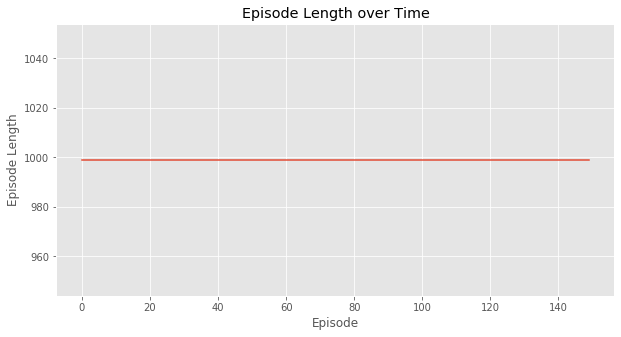

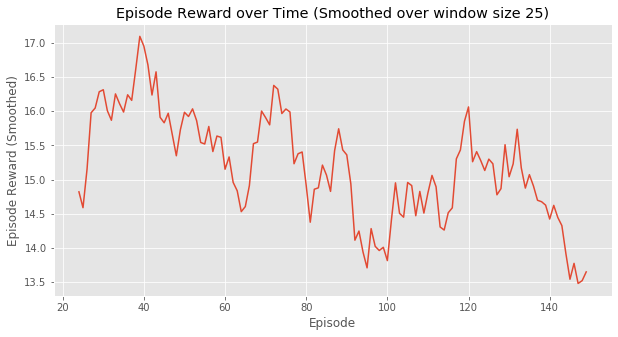

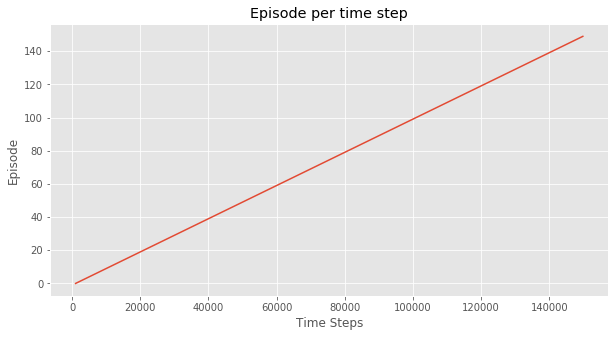

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [13]:
plotting.plot_episode_stats(stats, smoothing_window=25)